# Small Nimm 6 tournament

In [1]:
import numpy as np
import logging
import sys
import torch
import pickle
from tqdm import tqdm
from matplotlib import pyplot as plt

sys.path.append("../")

from rl_6_nimmt import Tournament, GameSession
from rl_6_nimmt.agents import Human, DrunkHamster, BatchedACERAgent, Noisy_D3QN_PRB_NStep, MCSAgent, PolicyMCSAgent, PUCTAgent

logging.basicConfig(format="%(message)s",level=logging.INFO)
for name in logging.root.manager.loggerDict:
    if not "rl_6_nimmt" in name:
        logging.getLogger(name).setLevel(logging.WARNING)


## Agents

In [2]:
agents = {}
    
agents[f"Random"] = DrunkHamster()
agents[f"D3QN"] = Noisy_D3QN_PRB_NStep(history_length=int(1e5), n_steps=10)
agents[f"ACER"] = BatchedACERAgent(minibatch=10)
agents[f"MCS"] = MCSAgent(mc_max=200)
agents[f"Alpha0.5"] = PUCTAgent(mc_max=200)

for agent in agents.values():
    try:
        agent.train()
    except:
        pass

merle = Human("Merle")


In [3]:
tournament = Tournament(min_players=2, max_players=4)

for name, agent in agents.items():
    tournament.add_player(name, agent)

print(tournament)

Tournament after 0 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
               Random |     0 |          - |            - | 1600 
                 D3QN |     0 |          - |            - | 1600 
                 ACER |     0 |          - |            - | 1600 
                  MCS |     0 |          - |            - | 1600 
             Alpha0.5 |     0 |          - |            - | 1600 
-----------------------------------------------------------------


## Load existing state (skip when running this for the first time)

In [13]:
agents, tournament = pickle.load(open("./.tournament.pickle", "rb"))

print(tournament)

Tournament after 2000 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
          MCS_0_0_0_0 |  1055 |      -7.13 |         0.46 | 1772 
          MCS_0_0_0_1 |  1075 |      -7.11 |         0.45 | 1770 
     Alpha0.5_0_1_1_0 |  1022 |      -6.76 |         0.48 | 1695 
     Alpha0.5_0_1_0_0 |  1033 |      -6.53 |         0.50 | 1739 
         ACER_0_0_0_0 |  1032 |     -12.50 |         0.18 | 1639 
       Random_0_0_0_0 |  1057 |     -13.42 |         0.21 | 1572 
-----------------------------------------------------------------
           Alpha0.5_1 |   458 |      -6.23 |         0.52 | 1812 
         Alpha0.5_0_0 |   657 |      -6.28 |         0.52 | 1713 
           D3QN_0_0_0 |   815 |     -13.19 |         0.18 | 1494 
-----------------------------------------------------------------


## Let the games begin! Stage 1: 5 x 400 games, 6 players, 200 MC steps

In [5]:
num_games = 2000
block_len = 400

try:
    tqdm._instances.clear()  # Important after cancelling any step
except:
    pass

while tournament.total_games < num_games:
    for _ in tqdm(range(block_len)):
        tournament.play_game()
    print(tournament)
        
    if tournament.total_games < num_games:
        tournament.evolve(max_players=6, max_per_descendant=2, copies=(2,))


  0%|          | 0/400 [00:00<?, ?it/s]../rl_6_nimmt/agents/mcts.py:302: RuntimeWarning: invalid value encountered in true_divide
  q = np.clip((q - min_return) / (max_return - min_return), 0., 1.)
  2%|▏         | 6/400 [01:57<2:04:58, 19.03s/it]../rl_6_nimmt/agents/mcts.py:302: RuntimeWarning: invalid value encountered in true_divide
  q = np.clip((q - min_return) / (max_return - min_return), 0., 1.)
  4%|▍         | 15/400 [04:59<2:15:37, 21.14s/it]../rl_6_nimmt/agents/mcts.py:302: RuntimeWarning: invalid value encountered in true_divide
  q = np.clip((q - min_return) / (max_return - min_return), 0., 1.)
100%|██████████| 400/400 [2:23:07<00:00, 21.47s/it]  
Copying player Alpha0.5 into 2 instances!


Tournament after 400 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
               Random |   227 |     -11.82 |         0.23 | 1423 
                 D3QN |   238 |     -11.92 |         0.22 | 1566 
                 ACER |   242 |     -13.74 |         0.17 | 1558 
                  MCS |   237 |      -6.87 |         0.50 | 1659 
             Alpha0.5 |   243 |      -6.16 |         0.56 | 1794 
-----------------------------------------------------------------


100%|██████████| 400/400 [3:21:44<00:00, 30.26s/it]  
Copying player Alpha0.5_0 into 2 instances!
Removing player Alpha0.5_1


Tournament after 800 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
           Alpha0.5_0 |   442 |      -6.19 |         0.54 | 1829 
           Alpha0.5_1 |   458 |      -6.23 |         0.52 | 1812 
                MCS_0 |   445 |      -6.98 |         0.47 | 1729 
               D3QN_0 |   422 |     -12.50 |         0.19 | 1450 
               ACER_0 |   437 |     -13.40 |         0.18 | 1546 
             Random_0 |   433 |     -12.87 |         0.21 | 1428 
-----------------------------------------------------------------


100%|██████████| 400/400 [3:51:54<00:00, 34.79s/it]    
Copying player Alpha0.5_0_1 into 2 instances!
Removing player Alpha0.5_0_0


Tournament after 1200 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
         Alpha0.5_0_0 |   657 |      -6.28 |         0.52 | 1713 
         Alpha0.5_0_1 |   636 |      -6.39 |         0.52 | 1776 
              MCS_0_0 |   648 |      -7.00 |         0.46 | 1695 
             ACER_0_0 |   632 |     -13.03 |         0.17 | 1503 
             D3QN_0_0 |   637 |     -12.85 |         0.18 | 1487 
           Random_0_0 |   652 |     -13.11 |         0.21 | 1637 
-----------------------------------------------------------------
           Alpha0.5_1 |   458 |      -6.23 |         0.52 | 1812 
-----------------------------------------------------------------


100%|██████████| 400/400 [2:54:42<00:00, 26.21s/it]  
Copying player MCS_0_0_0 into 2 instances!


Tournament after 1600 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
       Alpha0.5_0_1_0 |   828 |      -6.41 |         0.51 | 1718 
       Alpha0.5_0_1_1 |   833 |      -6.45 |         0.51 | 1756 
            MCS_0_0_0 |   858 |      -6.99 |         0.47 | 1807 
         Random_0_0_0 |   858 |     -13.22 |         0.21 | 1548 
           ACER_0_0_0 |   835 |     -12.60 |         0.18 | 1551 
           D3QN_0_0_0 |   815 |     -13.19 |         0.18 | 1494 
-----------------------------------------------------------------
           Alpha0.5_1 |   458 |      -6.23 |         0.52 | 1812 
         Alpha0.5_0_0 |   657 |      -6.28 |         0.52 | 1713 
-----------------------------------------------------------------


Removing player D3QN_0_0_0
100%|██████████| 400/400 [3:13:00<00:00, 28.95s/it]  

Tournament after 2000 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
          MCS_0_0_0_0 |  1055 |      -7.13 |         0.46 | 1772 
          MCS_0_0_0_1 |  1075 |      -7.11 |         0.45 | 1770 
     Alpha0.5_0_1_1_0 |  1022 |      -6.76 |         0.48 | 1695 
     Alpha0.5_0_1_0_0 |  1033 |      -6.53 |         0.50 | 1739 
         ACER_0_0_0_0 |  1032 |     -12.50 |         0.18 | 1639 
       Random_0_0_0_0 |  1057 |     -13.42 |         0.21 | 1572 
-----------------------------------------------------------------
           Alpha0.5_1 |   458 |      -6.23 |         0.52 | 1812 
         Alpha0.5_0_0 |   657 |      -6.28 |         0.52 | 1713 
           D3QN_0_0_0 |   815 |     -13.19 |         0.18 | 1494 
-----------------------------------------------------------------


In [6]:
pickle.dump((agents, tournament), open( "./.tournament.pickle", "wb" ))

## Stage 2: 3 x 400 games, 4 players, 400 MC steps

In [14]:
num_games = 3200
block_len = 400

for agent in tournament.agents:
    try:
        agent.mc_max = 400
    except:
        pass
    
tournament.elo_k = 16

try:
    tqdm._instances.clear()  # Important after cancelling any step
except:
    pass

while tournament.total_games < num_games:
    tournament.evolve(max_players=4, max_per_descendant=2, copies=(2,))
    for _ in tqdm(range(block_len)):
        tournament.play_game()
    print(tournament)


Copying player MCS_0_0_0_0 into 2 instances!
Removing player MCS_0_0_0_1
Removing player ACER_0_0_0_0
Removing player Random_0_0_0_0
100%|██████████| 400/400 [5:13:01<00:00, 46.95s/it]   
Copying player Alpha0.5_0_1_1_0_0 into 2 instances!
Removing player Alpha0.5_0_1_0_0_0
  0%|          | 0/400 [00:00<?, ?it/s]

Tournament after 2400 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
        MCS_0_0_0_0_0 |  1352 |      -7.71 |         0.43 | 1722 
        MCS_0_0_0_0_1 |  1363 |      -7.69 |         0.42 | 1709 
   Alpha0.5_0_1_0_0_0 |  1324 |      -7.10 |         0.47 | 1754 
   Alpha0.5_0_1_1_0_0 |  1318 |      -7.25 |         0.45 | 1793 
-----------------------------------------------------------------
           Alpha0.5_1 |   458 |      -6.23 |         0.52 | 1812 
         Alpha0.5_0_0 |   657 |      -6.28 |         0.52 | 1713 
           D3QN_0_0_0 |   815 |     -13.19 |         0.18 | 1494 
          MCS_0_0_0_1 |  1075 |      -7.11 |         0.45 | 1770 
         ACER_0_0_0_0 |  1032 |     -12.50 |         0.18 | 1639 
       Random_0_0_0_0 |  1057 |     -13.42 |         0.21 | 1572 
-----------------------------------------------

100%|██████████| 400/400 [4:42:03<00:00, 42.31s/it]  
Copying player Alpha0.5_0_1_1_0_0_1 into 2 instances!
Removing player Alpha0.5_0_1_1_0_0_0
  0%|          | 0/400 [00:00<?, ?it/s]

Tournament after 2800 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
 Alpha0.5_0_1_1_0_0_0 |  1621 |      -7.52 |         0.44 | 1721 
 Alpha0.5_0_1_1_0_0_1 |  1616 |      -7.73 |         0.42 | 1806 
      MCS_0_0_0_0_0_0 |  1661 |      -8.00 |         0.41 | 1795 
      MCS_0_0_0_0_1_0 |  1666 |      -8.04 |         0.40 | 1695 
-----------------------------------------------------------------
           Alpha0.5_1 |   458 |      -6.23 |         0.52 | 1812 
         Alpha0.5_0_0 |   657 |      -6.28 |         0.52 | 1713 
           D3QN_0_0_0 |   815 |     -13.19 |         0.18 | 1494 
          MCS_0_0_0_1 |  1075 |      -7.11 |         0.45 | 1770 
         ACER_0_0_0_0 |  1032 |     -12.50 |         0.18 | 1639 
       Random_0_0_0_0 |  1057 |     -13.42 |         0.21 | 1572 
   Alpha0.5_0_1_0_0_0 |  1324 |      -7.10 |   

100%|██████████| 400/400 [4:58:27<00:00, 44.77s/it]  

Tournament after 3200 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
 Alpha0.5_0_1_1_0_0_1_0 |  1932 |      -7.92 |         0.41 | 1764 
 Alpha0.5_0_1_1_0_0_1_1 |  1916 |      -8.02 |         0.41 | 1692 
    MCS_0_0_0_0_0_0_0 |  1954 |      -8.16 |         0.39 | 1819 
    MCS_0_0_0_0_1_0_0 |  1970 |      -8.26 |         0.39 | 1827 
-----------------------------------------------------------------
           Alpha0.5_1 |   458 |      -6.23 |         0.52 | 1812 
         Alpha0.5_0_0 |   657 |      -6.28 |         0.52 | 1713 
           D3QN_0_0_0 |   815 |     -13.19 |         0.18 | 1494 
          MCS_0_0_0_1 |  1075 |      -7.11 |         0.45 | 1770 
         ACER_0_0_0_0 |  1032 |     -12.50 |         0.18 | 1639 
       Random_0_0_0_0 |  1057 |     -13.42 |         0.21 | 1572 
   Alpha0.5_0_1_0_0_0 |  1324 |      -7.10 

In [15]:
pickle.dump((agents, tournament), open( "./.tournament2.pickle", "wb" ))

## A few more games to fine-tune the ELO ratings

In [21]:
tournament.remove_player("Alpha0.5_1", True)
tournament.remove_player("Alpha0.5_0_0", True)
tournament.remove_player("Alpha0.5_0_1_0_0_0", True)
tournament.remove_player("Alpha0.5_0_1_1_0_0_0", True)
tournament.remove_player("MCS_0_0_0_1", True)

tournament.active["D3QN_0_0_0"] = True
tournament.active["ACER_0_0_0_0"] = True
tournament.active["Random_0_0_0_0"] = True

print(tournament)

Tournament after 3200 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
           D3QN_0_0_0 |   815 |     -13.19 |         0.18 | 1494 
         ACER_0_0_0_0 |  1032 |     -12.50 |         0.18 | 1639 
       Random_0_0_0_0 |  1057 |     -13.42 |         0.21 | 1572 
 Alpha0.5_0_1_1_0_0_1_0 |  1932 |      -7.92 |         0.41 | 1764 
 Alpha0.5_0_1_1_0_0_1_1 |  1916 |      -8.02 |         0.41 | 1692 
    MCS_0_0_0_0_0_0_0 |  1954 |      -8.16 |         0.39 | 1819 
    MCS_0_0_0_0_1_0_0 |  1970 |      -8.26 |         0.39 | 1827 
-----------------------------------------------------------------


In [ ]:
num_games_per_k = 200    
elo_ks = 32, 16, 8, 4

for k in elo_ks:
    tournament.elo_k = k

    for _ in tqdm(range(num_games_per_k)):
        tournament.play_game()


  5%|▌         | 10/200 [03:22<59:01, 18.64s/it] ../rl_6_nimmt/agents/mcts.py:302: RuntimeWarning: invalid value encountered in true_divide
  q = np.clip((q - min_return) / (max_return - min_return), 0., 1.)
 14%|█▎        | 27/200 [13:11<1:15:06, 26.05s/it]

In [ ]:
pickle.dump((agents, tournament), open( "./.tournament3.pickle", "wb" ))

## Results

In [16]:
print(tournament)

Tournament after 3200 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
 Alpha0.5_0_1_1_0_0_1_0 |  1932 |      -7.92 |         0.41 | 1764 
 Alpha0.5_0_1_1_0_0_1_1 |  1916 |      -8.02 |         0.41 | 1692 
    MCS_0_0_0_0_0_0_0 |  1954 |      -8.16 |         0.39 | 1819 
    MCS_0_0_0_0_1_0_0 |  1970 |      -8.26 |         0.39 | 1827 
-----------------------------------------------------------------
           Alpha0.5_1 |   458 |      -6.23 |         0.52 | 1812 
         Alpha0.5_0_0 |   657 |      -6.28 |         0.52 | 1713 
           D3QN_0_0_0 |   815 |     -13.19 |         0.18 | 1494 
          MCS_0_0_0_1 |  1075 |      -7.11 |         0.45 | 1770 
         ACER_0_0_0_0 |  1032 |     -12.50 |         0.18 | 1639 
       Random_0_0_0_0 |  1057 |     -13.42 |         0.21 | 1572 
   Alpha0.5_0_1_0_0_0 |  1324 |      -7.10 

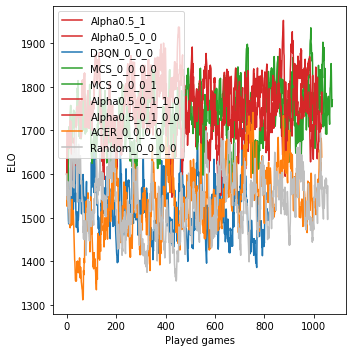

In [11]:
def plot_running_mean(x, y, n=10, **kwargs):
    cumsum = np.cumsum(np.insert(y, 0, 0))
    running_mean_y = (cumsum[n:] - cumsum[:-n]) / n
    
    cumsum = np.cumsum(np.insert(x, 0, 0))
    running_mean_x = (cumsum[n:] - cumsum[:-n]) / n
    
    plt.plot(running_mean_x, running_mean_y, **kwargs)

colors = {
    "D3QN": "C0",
    "ACER": "C2",
    "MCS": "C1",
    "Alpha0.5": "C3",
    "Random": "0.75",
}

fig = plt.figure(figsize=(5,5))
    
for name in tournament.agents.keys():
    done = {}
    name_ = name.split("_")[0]
    y = tournament.elos[name]
    x = np.arange(len(y))
    plot_running_mean(
        x,
        y,
        n=10
        label=None if name_ in done else name_,
        color=colors[name_],
        ls="-",
        lw=1.
    )
    done[name_] = True

plt.legend(loc="lower left")
        
plt.xlabel("Played games")
plt.ylabel("ELO")

plt.tight_layout()
plt.savefig("elo_2-4.pdf")


In [10]:
# def plot_running_mean(x, y, n=10, **kwargs):
#     cumsum = np.cumsum(np.insert(y, 0, 0))
#     running_mean_y = (cumsum[n:] - cumsum[:-n]) / n
    
#     cumsum = np.cumsum(np.insert(x, 0, 0))
#     running_mean_x = (cumsum[n:] - cumsum[:-n]) / n
    
#     plt.plot(running_mean_x, running_mean_y, **kwargs)

# labels = [
#     "Mean Hornochsen in tournament",
#     "Mean Hornochsen vs baseline",
#     "Win fraction in tournament",
#     "Win fraction vs baseline"
# ]
# quantities = [
#     tournament.tournament_scores,
#     tournament.baseline_scores,
#     tournament.tournament_wins,
#     tournament.baseline_wins
# ]
# fns = [lambda x : -x, lambda x : -x, lambda x : x, lambda x : x]
# baselines = [False, True, False, True]

# colors = {
#     "D3QN": "C0",
#     "ACER": "C1",
#     "MCS": "C2",
#     "Alpha0.5": "C3",
#     "Random": "0.6",
# }
# lss = {
#     "D3QN": "-",
#     "ACER": "-",
#     "MCS": "-",
#     "Alpha0.5": "-",
#     "Random": "-",
# }

# fig = plt.figure(figsize=(10,10))

# for panel, (quantity, label, fn, baseline) in enumerate(zip(quantities, labels, fns, baselines)):
#     ax = plt.subplot(2,2,panel + 1)
    
#     for name in tournament.agents.keys():
#         y = np.array(quantity[name])
#         x = 10 * np.arange(1, len(y) + 1) if baseline else np.arange(1, len(y) + 1)
#         plot_running_mean(x, fn(y), n=50 if baseline else 200, label=name, color=colors[name.split("_")[0]], ls=lss[name.split("_")[0]], lw=1.)
    
#     if panel == 0:
#         plt.legend(loc="center left")
        
#     plt.xlabel("Played tournament games")
#     plt.ylabel(label)

# plt.tight_layout()
# plt.savefig("tournament_results.pdf")


## Winner vs Merle

In [18]:
print(tournament)

Tournament after 2223 games:
----------------------------------------------------------------------------------------------------
 Agent                | Games | Tournament score | Tournament wins | Baseline score | Baseline wins 
----------------------------------------------------------------------------------------------------
     Alpha0.5_0_1_1_0 |   819 |            -5.24 |            0.62 |          -4.36 |          0.79 
     Alpha0.5_0_1_1_1 |   816 |            -5.21 |            0.61 |          -4.53 |          0.77 
          MCS_1_0_0_0 |   810 |            -5.74 |            0.56 |          -4.30 |          0.77 
          MCS_0_0_0_0 |   821 |            -6.01 |            0.52 |          -4.70 |          0.80 
----------------------------------------------------------------------------------------------------
[              Random |   175 |            -9.32 |            0.31 |          -9.00 |          0.47]
[              D3QN_0 |   348 |            -9.01 |            

In [19]:
tournament.active_agents()

['Alpha0.5_0_1_1_0', 'Alpha0.5_0_1_1_1', 'MCS_1_0_0_0', 'MCS_0_0_0_0']

In [20]:
opponent1 = tournament.agents['Alpha0.5_0_1_1_1']
opponent1.mc_max = 500

opponent2 = tournament.agents['Alpha0.5_0_1_1_1']
opponent2.mc_max = 200

session = GameSession(merle, opponent1, opponent2)

# The DEBUG output shows the moves, which is nice
for name in logging.root.manager.loggerDict:
    if "rl_6_nimmt" in name:
        logging.getLogger(name).setLevel(logging.DEBUG)
        

In [21]:
session.play_game(render=True)

Dealing cards
------------------------------------------------------------------------------------------------------------------------
Board:
   30:   _    _    _    _    * 
   85.   _    _    _    _    * 
   10:   _    _    _    _    * 
   18    _    _    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards   7   20:  31   32   42   46   73   96  101  103 
  Alpha0.5 (player 2):   0 Hornochsen, cards  29   38   40:  45.  48   50:  61   72   74   90:
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   7  20  31  32  42  46  73  96 101 103. Choose one to play! 96


AlphaAlmostZero thoughts:
     29: p = 0.10, n = 100, E[r] =  -7.4
     38: p = 0.10, n =  39, E[r] =  -9.9
     40: p = 0.10, n =  70, E[r] =  -8.1
     45: p = 0.10, n =  84, E[r] =  -7.7
     48: p = 0.10, n =  79, E[r] =  -7.8
     50: p = 0.10, n =  58, E[r] =  -8.6
     61: p = 0.10, n =  77, E[r] =  -7.8
  x  72: p = 0.10, n = 266, E[r] =  -6.3
     74: p = 0.10, n =  73, E[r] =  -8.0
     90: p = 0.10, n = 154, E[r] =  -6.8
Alpha0.5 (player 2) plays card 72
Merle    (player 1) plays card 96
------------------------------------------------------------------------------------------------------------------------
Board:
   30:  72    _    _    _    * 
   85.  96    _    _    _    * 
   10:   _    _    _    _    * 
   18    _    _    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards   7   20:  31   32   42   46   73  101  103 
  Alpha0.5 (player 2):   0 Hornochsen, cards  29   38   40:  45.  48   50:  61   74   90:
---------------------------------------------------

It is your turn, Merle! You have the following cards:   7  20  31  32  42  46  73 101 103. Choose one to play! 20


AlphaAlmostZero thoughts:
     29: p = 0.11, n =  87, E[r] =  -6.9
     38: p = 0.11, n = 116, E[r] =  -6.5
     40: p = 0.11, n =  59, E[r] =  -7.9
     45: p = 0.11, n =  69, E[r] =  -7.6
     48: p = 0.11, n = 132, E[r] =  -6.3
     50: p = 0.11, n = 102, E[r] =  -6.6
  x  61: p = 0.11, n = 188, E[r] =  -5.8
     74: p = 0.11, n = 145, E[r] =  -6.1
     90: p = 0.12, n = 102, E[r] =  -6.9
Merle    (player 1) plays card 20
Alpha0.5 (player 2) plays card 61
------------------------------------------------------------------------------------------------------------------------
Board:
   30:  72    _    _    _    * 
   85.  96    _    _    _    * 
   10:   _    _    _    _    * 
   18   20:  61    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards   7   31   32   42   46   73  101  103 
  Alpha0.5 (player 2):   0 Hornochsen, cards  29   38   40:  45.  48   50:  74   90:
------------------------------------------------------------------------------------------------------

It is your turn, Merle! You have the following cards:   7  31  32  42  46  73 101 103. Choose one to play! 31


AlphaAlmostZero thoughts:
     29: p = 0.11, n = 128, E[r] =  -6.3
  x  38: p = 0.12, n = 148, E[r] =  -6.1
     40: p = 0.12, n = 115, E[r] =  -6.6
     45: p = 0.12, n = 137, E[r] =  -6.3
     48: p = 0.12, n =  51, E[r] =  -8.9
     50: p = 0.12, n = 105, E[r] =  -6.8
     74: p = 0.14, n = 126, E[r] =  -6.8
     90: p = 0.15, n = 190, E[r] =  -6.2
Merle    (player 1) plays card 31
Alpha0.5 (player 2) plays card 38
------------------------------------------------------------------------------------------------------------------------
Board:
   30:  72    _    _    _    * 
   85.  96    _    _    _    * 
   10:  31   38    _    _    * 
   18   20:  61    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards   7   32   42   46   73  101  103 
  Alpha0.5 (player 2):   0 Hornochsen, cards  29   40:  45.  48   50:  74   90:
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   7  32  42  46  73 101 103. Choose one to play! 46


AlphaAlmostZero thoughts:
     29: p = 0.13, n = 102, E[r] =  -7.0
     40: p = 0.13, n =  69, E[r] =  -8.1
     45: p = 0.13, n = 117, E[r] =  -6.8
     48: p = 0.14, n = 119, E[r] =  -6.8
  x  50: p = 0.14, n = 205, E[r] =  -6.0
     74: p = 0.16, n = 141, E[r] =  -6.7
     90: p = 0.18, n = 247, E[r] =  -6.1
Merle    (player 1) plays card 46
Alpha0.5 (player 2) plays card 50
------------------------------------------------------------------------------------------------------------------------
Board:
   30:  72    _    _    _    * 
   85.  96    _    _    _    * 
   10:  31   38   46   50:   * 
   18   20:  61    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards   7   32   42   73  101  103 
  Alpha0.5 (player 2):   0 Hornochsen, cards  29   40:  45.  48   74   90:
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   7  32  42  73 101 103. Choose one to play! 73


AlphaAlmostZero thoughts:
     29: p = 0.12, n =  63, E[r] =  -7.1
     40: p = 0.14, n =  72, E[r] =  -7.1
     45: p = 0.14, n =  72, E[r] =  -7.1
     48: p = 0.15, n =  71, E[r] =  -7.3
  x  74: p = 0.20, n = 365, E[r] =  -4.7
     90: p = 0.25, n = 357, E[r] =  -4.9
Merle    (player 1) plays card 73
Alpha0.5 (player 2) plays card 74
------------------------------------------------------------------------------------------------------------------------
Board:
   30:  72   73   74    _    * 
   85.  96    _    _    _    * 
   10:  31   38   46   50:   * 
   18   20:  61    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards   7   32   42  101  103 
  Alpha0.5 (player 2):   0 Hornochsen, cards  29   40:  45.  48   90:
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   7  32  42 101 103. Choose one to play! 101


AlphaAlmostZero thoughts:
     29: p = 0.14, n = 111, E[r] =  -6.3
     40: p = 0.16, n =  93, E[r] =  -7.1
     45: p = 0.17, n =  91, E[r] =  -7.3
     48: p = 0.18, n = 130, E[r] =  -6.5
  x  90: p = 0.35, n = 575, E[r] =  -5.3
Alpha0.5 (player 2) plays card 90
Merle    (player 1) plays card 101
------------------------------------------------------------------------------------------------------------------------
Board:
   30:  72   73   74   90:   * 
   85.  96  101    _    _    * 
   10:  31   38   46   50:   * 
   18   20:  61    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards   7   32   42  103 
  Alpha0.5 (player 2):   0 Hornochsen, cards  29   40:  45.  48 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   7  32  42 103. Choose one to play! 32


AlphaAlmostZero thoughts:
  x  29: p = 0.22, n =  97, E[r] =  -4.2
     40: p = 0.25, n =  42, E[r] =  -5.5
     45: p = 0.26, n =  39, E[r] =  -5.8
     48: p = 0.27, n =  62, E[r] =  -5.0
Alpha0.5 (player 2) plays card 29
  ...chooses to replace row 2
  ...and gains 4 Hornochsen
Merle    (player 1) plays card 32
------------------------------------------------------------------------------------------------------------------------
Board:
   30:  72   73   74   90:   * 
   29   32    _    _    _    * 
   10:  31   38   46   50:   * 
   18   20:  61    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards   7   42  103 
  Alpha0.5 (player 2):   4 Hornochsen, cards  40:  45.  48 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   7  42 103. Choose one to play! 7


AlphaAlmostZero thoughts:
  x  40: p = 0.33, n =  30, E[r] =  -0.8
     45: p = 0.33, n =  19, E[r] =  -1.4
     48: p = 0.34, n =  11, E[r] =  -3.2
Merle    (player 1) plays card 7
  ...chooses to replace row 2
  ...and gains 2 Hornochsen
Alpha0.5 (player 2) plays card 40
------------------------------------------------------------------------------------------------------------------------
Board:
   30:  72   73   74   90:   * 
    7   40:   _    _    _    * 
   10:  31   38   46   50:   * 
   18   20:  61    _    _    * 
Players:
  Merle    (player 1):   2 Hornochsen, cards  42  103 
  Alpha0.5 (player 2):   4 Hornochsen, cards  45.  48 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  42 103. Choose one to play! 42


AlphaAlmostZero thoughts:
  x  45: p = 0.50, n =  14, E[r] =   0.0
     48: p = 0.50, n =   6, E[r] =  -1.7
Merle    (player 1) plays card 42
Alpha0.5 (player 2) plays card 45
------------------------------------------------------------------------------------------------------------------------
Board:
   30:  72   73   74   90:   * 
    7   40:  42   45.   _    * 
   10:  31   38   46   50:   * 
   18   20:  61    _    _    * 
Players:
  Merle    (player 1):   2 Hornochsen, cards 103 
  Alpha0.5 (player 2):   4 Hornochsen, cards  48 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards: 103. Choose one to play! 103


Alpha0.5 (player 2) plays card 48
Merle    (player 1) plays card 103
  ...and gains 9 Hornochsen
------------------------------------------------------------------------------------------------------------------------
Board:
  103    _    _    _    _    * 
    7   40:  42   45.  48    * 
   10:  31   38   46   50:   * 
   18   20:  61    _    _    * 
Players:
  Merle    (player 1):  11 Hornochsen, no cards 
  Alpha0.5 (player 2):   4 Hornochsen, no cards 
The game is over! Alpha0.5 (player 2) wins, Merle    (player 1) loses. Congratulations!
------------------------------------------------------------------------------------------------------------------------
